# Introduction

## Objective

This project has two main objectives: the first is to determine whether it is possible to predict stock market returns using machine learning (ML) techniques. Initially, the only inputs to our ML models are past returns, but later we engineer additional data features and explore whether they improve prediction accuracy.

The second objective is to acquire a deeper understanding of these machine learning techniques by implementing some of them ourselves. Due to time constraints, we were only able to implement logistic regression. For other techniques, we rely on the implementation in the popular scikit-learn library.

## Structure

The report is divided into two parts. In part one, we attempt to predict the direction of future stock returns using previous returns only. We demonstrate our implementation of logistic regression and apply it to this task. Then we apply support vector machines and decision trees from scikit-learn.

In part two, we add additional data features: returns volatility, calculated using our own implementation of the Yang-Zhang estimator, and the MACD technical indicator.


## Code

This report was created using Jupyter Notebook, a format that allows rich text, equations, charts, and working code to coexist in the same document. The Jupyter Notebook was converted to pdf using the nbconvert library (behind the scenes, the notebook is converted to LaTeX format which is then converted to pdf).

The .zip folder submitted together with this report contains several folders. The notebooks folder contains the original version of this report. The publication folder contains this pdf and other files related to report publication and submission. The src folder contains code that we wrote, for example to implement logistic regression or calculate volatility.

The environment used to execute code in this project is Anaconda 5.2.0 (Python 3.6), running on macOS 10.11.6. To convert notebooks to pdf format, nbconvert requires a TeX distribution to be installed. We used MacTex 2018, available from https://tug.org/mactex/mactex-download.html

We begin by setting our working directory to the src folder:

In [1]:
%cd -q ../src

Now we import the numpy, pandas, and matplotlib packages, and adjust their settings:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# set max number of rows for display
pd.set_option('max_rows', 11)

# set how figures are displayed and their default size
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

## Data

We use stock price data for Microsoft (NASDAQ: MSFT), downloaded from Yahoo Finance: https://finance.yahoo.com/quote/MSFT/

The file MSFT.csv contains a history of prices starting on 13 March 1986 (the day Microsoft went public). We import this file into a Pandas DataFrame.

In [4]:
raw_data = pd.read_csv('../data/MSFT.csv', index_col='Date', parse_dates=True)
raw_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-03-13,0.088542,0.101563,0.088542,0.097222,0.070555,1031788800
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.073075,308160000
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.074335,133171200
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.072445,67766400
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.071185,47894400


The data set consists of open, high, low, close (OHLC), adjusted close, and volume. To begin with, we only make use of the adjusted close column. However, later we will use the OHLC prices to calculate volatility.

We now plot the adjusted close price over time.

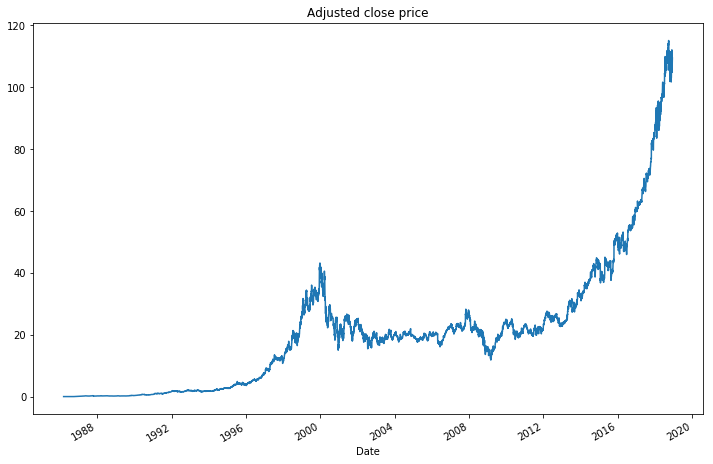

In [5]:
raw_data['Adj Close'].plot(title='Adjusted close price');

# Part 1: predicting direction using past returns only

## Preliminaries

We begin by calculating daily returns using the adjusted close price. We use log returns, so the return is defined as $\log(P_t) - \log(P_{t-p})$, where $P_t$ is the price on day $t$, and $p$ is the number of periods the return is calculated for ( $p=1$ for daily returns). Because daily returns are likely to contain a lot of noise, we use five-day returns.

In [6]:
period = 5
returns = np.log(raw_data['Adj Close']).diff(period)
returns.name = 'Returns'

Now we create a dataframe which consists of the five-day return on each date, and 10 lagged returns (the five-day return 5, 10, ..., and 50 days ago). we remove overlapping observations (so we are left with observations that are five days apart).

In [7]:
# dataframe of returns, with shifts
rdf = pd.DataFrame(returns)
for i in range(1,11):
    rdf['Returns_' + str(i)] = returns.shift(i*period)
rdf.dropna(inplace=True)
rdf = rdf.iloc[::-period].sort_index()

rdf

,Returns,Returns_1,Returns_2,Returns_3,Returns_4,Returns_5,Returns_6,Returns_7,Returns_8,Returns_9,Returns_10
Date,,,,,,,,,,,
1986-06-04,0.022474,0.046523,-0.023532,0.015626,-0.038618,0.137867,-0.008659,0.053114,0.009133,0.046960,-0.126303
1986-06-11,-0.030080,0.022474,0.046523,-0.023532,0.015626,-0.038618,0.137867,-0.008659,0.053114,0.009133,0.046960
1986-06-18,-0.038918,-0.030080,0.022474,0.046523,-0.023532,0.015626,-0.038618,0.137867,-0.008659,0.053114,0.009133
1986-06-25,-0.016002,-0.038918,-0.030080,0.022474,0.046523,-0.023532,0.015626,-0.038618,0.137867,-0.008659,0.053114
1986-07-02,-0.008098,-0.016002,-0.038918,-0.030080,0.022474,0.046523,-0.023532,0.015626,-0.038618,0.137867,-0.008659
...,...,...,...,...,...,...,...,...,...,...,...
2018-11-13,-0.007267,0.037744,-0.041265,-0.026473,-0.011287,-0.025418,0.006098,0.010894,0.017555,-0.004216,0.019069
2018-11-20,-0.045832,-0.007267,0.037744,-0.041265,-0.026473,-0.011287,-0.025418,0.006098,0.010894,0.017555,-0.004216
2018-11-28,0.088485,-0.045832,-0.007267,0.037744,-0.041265,-0.026473,-0.011287,-0.025418,0.006098,0.010894,0.017555


We calculate the correlation matrix between these returns and represent it as a heatmap. We are mainly interested in the first row (or column) of the matrix, since that contains the correlation between current returns and previous returns. Strong positive or negative correlations would suggest that previous returns may have good predictive power. 

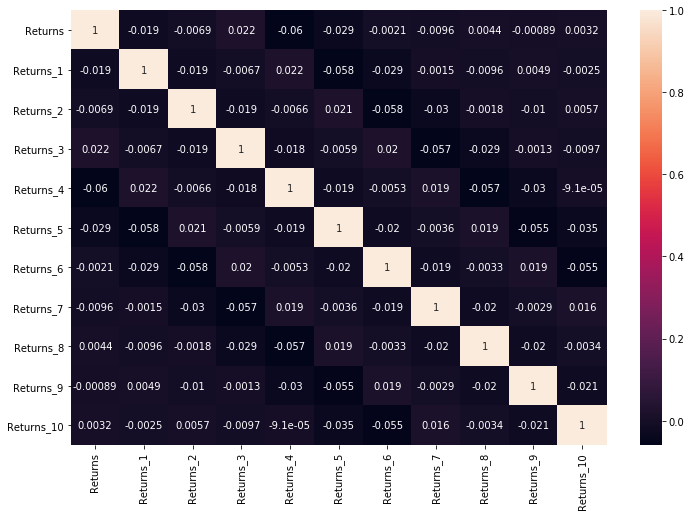

In [8]:
import seaborn as sns
sns.heatmap(rdf.corr(), annot=True);

Overall the correlations are very weak. However, this is a fairly primitive test of predictive power.

Before running ML techniques over our data, we split it into training and validation (or test) sets. Models will be trained on the training set and evaluated on the test set. To perform this split, a common approach is to use random sampling. This is appropriate when observations are independent (or at least unordered). However, this is not appropriate for time series: consecutive observations may form part of a trend which would not be visible to the model if the observations were randomly split between trainig and test sets.

Instead of random sampling, we split our dataset as follows: the first 80% of observations are in the training set, and the remaining observations form the test set. As a result, the training set runs from 1986 to mid 2012, and the test set from mid 2012 to late 2018.

The features are the lagged returns. The target is simply the sign of the current return, encoded as 0 for negative and 1 for positive - we are not attempting to predict magnitude of returns, only their direction.

In [9]:
# set up training and test datasets
train_proportion = 0.8
n = len(rdf)
t = round(n*train_proportion)

# test data is consecutive to training data
train_data = rdf.iloc[:t]
test_data = rdf.iloc[t:]

# target is sign of return, encoded as 0 for negative, 1 for positive
train_target = (train_data['Returns'] > 0).astype(int)
test_target = (test_data['Returns'] > 0).astype(int)

# features are lagged returns
train_features = train_data.drop(columns='Returns')
test_features = test_data.drop(columns='Returns')

We plot the target returns, differentiating the training and test sets by colour.

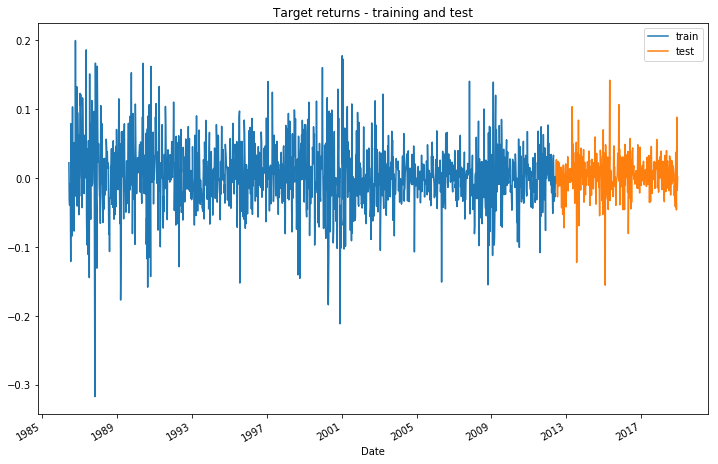

In [10]:
train_data['Returns'].plot(label='train', title='Target returns - training and test');
test_data['Returns'].plot(label='test');
plt.legend();

## Logistic regression

The first ML technique that we apply is logistic regression. Similarly to linear regression, logistic regression calculates a linear combination of the input features, but instead of outputting the result directly, we pass it through the *logistic function* in order to produce a probability. That probability is then used to estimate which of two classes an observation belongs to.

For a vector of coefficients $\mathbf{w}$ (including an intercept term at the beginning) and a feature vector $\mathbf{x}$ (this corresponds to a single observation with 1 inserted at the beginning for the intercept term), the estimated probability is:
$$\hat{p} = h_\mathbf{w}(\mathbf{x}) = \sigma(\mathbf{w}^T \mathbf{x})$$

where $\sigma$ is the logistic function, defined as:
$$\sigma(t) = \frac{1}{1+\exp(-t)}$$

If the probability $\hat{p}$ is greater than or equal to 0.5, the estimated class $\hat{y}$ is 1, otherwise $\hat{y}$ is 0.

To train the model we look for $\mathbf{w}$ that minimizes the following cost function, where $n$ is the number of observations:

$$J(\mathbf{w}) = -\sum_{i=1}^n y_i\log(\hat{p_i}) + (1-y_i)\log(1-\hat{p_i}) + DR$$

$R$ is the regularization term, defined as follows, where $k$ is the number of features plus one (for the intercept term):
- for L1 regularization, $R = \|{w}\|_1 = \sum_{i=1}^k |w_i|$
- for L2 regularization, $R = \frac{1}{2}\|{w}\|_2 = \frac{1}{2}\sum_{i=1}^k w_i^2$

$D$ is the regularization strength, a hyperparameter.

Note that the intercept term should not be penalized, however we are including it in the regularization term because this is consistent with the implementation in our version of scikit-learn (0.19.1). Indeed, prior to version 0.22 the default solver in `sklearn.linear_model.LogisticRegression` was `'liblinear'`, which did not support having an unconstrained intercept. See https://github.com/scikit-learn/scikit-learn/issues/10626

We use gradient descent to find the optimal $\mathbf{w}$. The gradient is:

$$\nabla J(\mathbf w) = -\mathbf{X}^T (\mathbf{y} - \mathbf{\hat{p}}) + D \nabla R$$

We stop iterating when the L2 norm of the gradient is sufficiently close to zero.

### Testing our implementation

To test our implementation of logistic regression, we run it on a dataset and compare the results with those we obtain with scikit-learn. The dataset is the famous "Iris" dataset, in which we classify iris flowers to varieties based on their attributes.

The features are as follows:

In [11]:
from sklearn import datasets

iris = datasets.load_iris()
features = pd.DataFrame(iris.data, columns=iris.feature_names)
features.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


There are three varieties:

In [12]:
target_names = dict(enumerate(iris.target_names))
targets = pd.Series(iris.target, name='variety').map(target_names)

pd.DataFrame(targets.sample(10, random_state=0)).sort_index()  # just for display

,variety
7,setosa
33,setosa
40,setosa
62,versicolor
71,versicolor
76,versicolor
86,versicolor
100,virginica
107,virginica
114,virginica


Logistic regression is a binary classifier, so we choose to classify observations as *Setosa* or other.

We split the dataset into training and test sets using scikit-learn's `train_test_split` function.

In [13]:
from sklearn.model_selection import train_test_split

# we want to classify as Iris-Setosa or not
target = (targets == 'setosa').astype('int')

# split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    features.values, target.values, test_size=0.4, random_state=0)

We use the following hyperparameters:

In [14]:
penalty = 'l2'  # regularization type
D = 1.0  # regularization strength
eta = 0.01  # learning rate for gradient descent
tol = 0.001  # stopping criterion for gradient descent
max_iter = 1000  # maximum number of iterations for gradient descent
scaling = False  # do not normalize features

Logistic regression works best when all the features have roughly the same scale. This is already the case for the Iris dataset, but for other datasets our logistic regressor can standardize the features (subtracting the mean of each feature from itself, then dividing by its standard deviation). This is done if we set `scaling = True`.

The scikit-learn implementation does not perform scaling itself, but it can be done using `sklearn.preprocessing.StandardScaler`.

We import our regressor and fit it to the data. Note that our API is inspired by scikit-learn, so the methods have similar names.

In [15]:
# our implementation
import regression as reg
rlg = reg.LogisticRegressor(penalty=penalty, D=D, eta=eta, tol=tol, max_iter=max_iter, scaling=scaling)
rlg.fit(X_train, y_train)

Completed optimization. Number of iterations: 686. Norm of gradient: 0.0009922925964287082.


We do the same for the scikit-learn implementation.

In [16]:
import sklearn.linear_model as skl
slg = skl.LogisticRegression(penalty=penalty, tol=tol, C=1/D, max_iter=max_iter)
slg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.001,
          verbose=0, warm_start=False)

Note that the scikit-learn user guide defines the logistic regression cost function in a slightly different way, as shown here: https://scikit-learn.org/0.19/modules/linear_model.html#logistic-regression

In scikit-learn's definition, $y$ takes values $-1$ or $1$ (this doesn't appear to be clearly stated anywhere) whereas in ours, $y$ takes values $0$ or $1$. Taking this into account, the two definitions can be shown to be equivalent. For details, see: https://stats.stackexchange.com/questions/235514/how-do-i-get-cost-function-of-logistic-regression-in-scikit-learn-from-log-likel

The parameter `C` is the inverse of the regularization strength, so we set `C=1/D`.

Having fitted both models, we now report the score:

In [17]:
print(rlg.score(X_test, y_test))
print(slg.score(X_test, y_test))

1.0
1.0


Both implementations report a perfect score on this dataset. This is possible because the *Setosa* variety is linearly separable from the others.

We now look at the coefficients:

In [18]:
coefs = rlg.get_coefs()
print(coefs.T)
print(slg.coef_)

[[ 0.40835796  1.2788054  -2.0494599  -0.95113462]]
[[ 0.41149429  1.27435999 -2.05171285 -0.95237787]]


Finally, we look at the intercept terms:

In [19]:
print(rlg.get_intercept())
print(slg.intercept_)

[0.24981823]
[0.25354022]


Our implementation produces coefficients that are almost identical to those produced by scikit-learn. This verifies that our implementation is correct.

### Applying logistic regression to predict returns

We now use the training and test data that we built earlier for MSFT and fit using the same hyperparameters. 

In [20]:
# the .values attribute returns a numpy array from our pandas objects
rlg.fit(train_features.values, train_target.values)
slg.fit(train_features.values, train_target.values)

Iteration stopped after reaching max_iter (1000).
Completed optimization. Number of iterations: 1000. Norm of gradient: 585.7127773237883.


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.001,
          verbose=0, warm_start=False)

Our implementation reports that it reached the maximum number of iterations before reducing the gradient to zero. Indeed, the norm of the gradient is very large: 585.7, well above our tolerance of 0.001!

The scikit-learn estimator does not report this information directly (though it may be possible to obtain it from the object's fields). We compare the coefficients obtained:

In [21]:
coefs = rlg.get_coefs()
print(coefs.T)
print(slg.coef_)

[[-0.14708363 -0.84251151  0.76517872 -1.27190097 -0.12480212 -0.17358803
   0.4194301   0.10317351 -0.25514715 -0.49309735]]
[[-0.09973018 -0.55721674  0.49115373 -0.83934588 -0.09570598 -0.14458808
   0.27310413  0.0429071  -0.18249535 -0.33379533]]


While not identical, the two sets of coefficients are quite similar. This leads us to suspect that neither implementation was able to find an ideal solution.

To find out more, we look at the scores:

In [22]:
print(rlg.score(test_features.values, test_target.values))
print(slg.score(test_features.values, test_target.values))

0.5792682926829268
0.5670731707317073


Indeed, the scores are similar - in fact, ours is slightly higher. Although both estimators are correct more than 50% of the time, these are not particularly good scores.

Now we carry out prediction on the test set and analyze the results using a confusion matrix, first for the scikit implementation then for ours.

First we define a convenience function `confusion_df` which takes the output of `sklearn.metrics.confusion_matrix` and converts it to a labelled dataframe for presentation purposes.

In [23]:
from sklearn.metrics import confusion_matrix

def confusion_df(test_target, test_predictions, labels=['down', 'up']):
    cm = confusion_matrix(test_target, test_predictions)
    return pd.DataFrame(cm, index=pd.Index(labels, name='target'), columns=pd.Index(labels, name='prediction'))

In [24]:
test_predictions = slg.predict(test_features)
confusion_df(test_target, test_predictions)

prediction,down,up
target,,
down,1,137
up,5,185


In [25]:
test_predictions = rlg.predict(test_features)
confusion_df(test_target, test_predictions)

prediction,down,up
target,,
down,0,138
up,0,190


Whereas scikit predicts six down returns (in other words, 1.83% of the time), our implementation predicts no down returns at all! However, it would seem that both estimators found that the best prediction was positive returns (almost) all the time.

Of course, these results depend on the data: as shown below, the MSFT dataset contained more positive returns than negative returns. If the opposite were true, it's likely that logistic regression would predict negative returns all the time.

In [26]:
np.sign(returns).value_counts()

 1.0    4479
-1.0    3702
 0.0      72
Name: Returns, dtype: int64

When we use L1 regularization, we find that most of the coefficients are zero, as shown below. This is expected, since L1 regularization has the property of performing feature selection, and our features don't appear to have any predictive power.

In [27]:
slg.penalty = 'l1'
slg.fit(train_features.values, train_target.values)
slg.coef_

array([[ 0.        , -0.0037068 ,  0.        , -0.62013987,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

To conclude, we can be certain that at least one of these statements is true:

1. Logistic regression is not an appropriate method, or we have chosen very bad hyperparameters.
2. We need more data, or different features (not just previous returns). 

## Support vector machine

We train a support vector machine classifier using a linear kernel and the default settings from scikit-learn (objective function: hinge loss squared, L2 penalty, regularization strength 1).

In [28]:
from sklearn.svm import LinearSVC

clf = LinearSVC()
clf.fit(train_features, train_target)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

The score is not improved:

In [29]:
clf.score(test_features, test_target)

0.5487804878048781

We compute the confusion matrix:

In [30]:
test_predictions = clf.predict(test_features)
confusion_df(test_target, test_predictions)

prediction,down,up
target,,
down,8,130
up,18,172


Similarly to logistic regression, the support vector machine predicts "up" almost all the time.

## Decision tree

We move on to a different type of classifier, the decision tree. We set the maximum depth to 3.

In [31]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=3, random_state=0)  # set the random state to make results reproducible
clf.fit(train_features, train_target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

The score is still poor:

In [32]:
clf.score(test_features, test_target)

0.5762195121951219

To visualize our tree, we need to install the `graphviz` package. This is achieved by running `conda install python-graphviz`.

In [33]:
import graphviz
from sklearn.tree import export_graphviz
dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=train_features.columns, 
                           class_names=['down', 'up'],
                           filled=True,
                           rounded=True,
                           proportion=True
                          )
graph = graphviz.Source(dot_data, filename='../notebooks/tree', format='png')
graph.render();

The tree is displayed below. Nodes are colour-coded by class (blue is down, red is up). The tint depends on the purity of the node: higher purity (lower gini) nodes are darker.

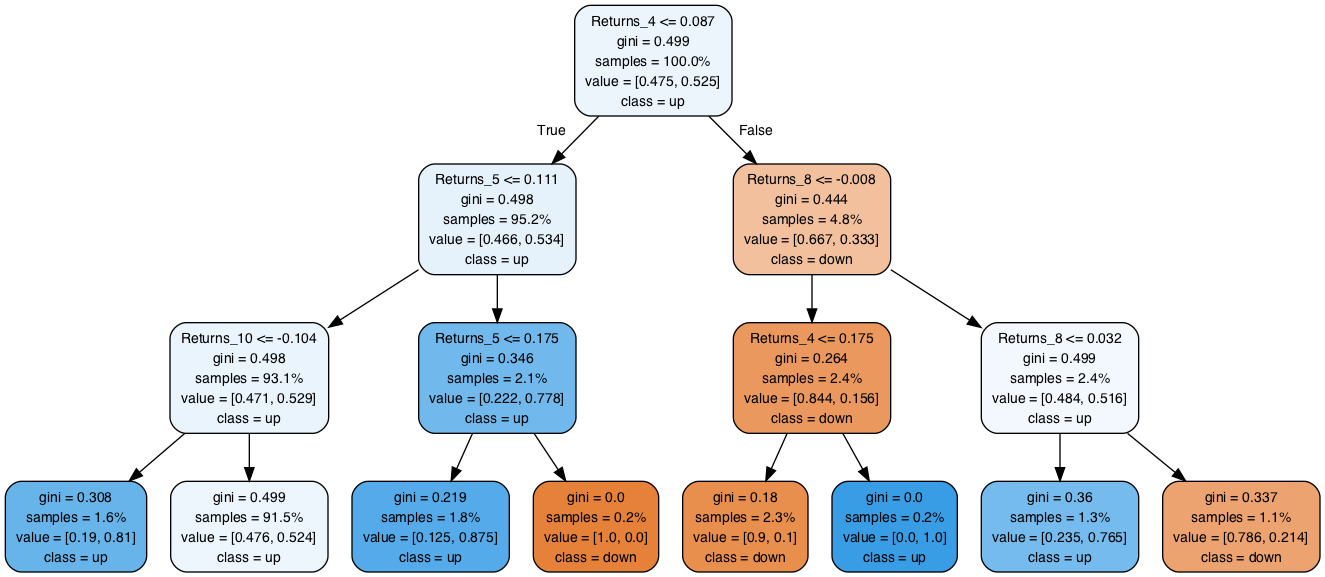

In [34]:
from IPython.display import Image
Image('../notebooks/tree.png')

A closer look at this tree reveals that it is predicting returns in a similar way to the other estimators we have tested. Indeed, it predicts "up" for 94.6% of the samples in the training set, and 91.5% of the samples end up in the second leaf from the right! In fact, the left-most two leaves are redundant since they both predict the same class.

# Part 2: engineering more features

## Volatility

Our existing feature set does not seem to have much predictive power, so we now turn to engineering more features. The first feature we add is volatility. We will use the Yang-Zhang volatility estimator (cited below), which uses open, high, low, and close (OHLC) prices to obtain a more precise estimate of volatility than using close price alone.

Yang, D. and Zhang, Q. (2000). Drift Independent Volatility Estimation Based on High, Low, Open, and Close Prices. The Journal of Business, [online] 73(3), pp.477-492. Available at: https://www.jstor.org/stable/10.1086/209650.

### Price adjustment

Our dataset contains OHLC prices, however before we can use them, we need to adjust them. All the columns in the Yahoo finance data are adjusted for stock splits. However, only the 'Adj Close' column is adjusted for dividends, using the following methodology.

Starting at the most recent date and going backwards in time, the adjusted and unadjusted close prices are equal until we reach the first (most recent) ex-dividend date $t_1$. The adjusted close price between $t_1$ and the next ex-date $t_2$ is equal to the close price multiplied by $\left( 1 - {D_{t_1}}/{C_{t_1^-}} \right)$, where $D_{t_1}$ is the amount of the dividend, and $C_{t_1^-}$ is the close price on the day prior to the ex-date.

Therefore, the adjustment ratio $A_t/C_t$ is given by the following expression, where $A_t$ is the adjusted close price at time $t$:

$$\frac{A_t}{C_t} = \prod_{i\ :\ t_i \gt t} \left( 1 - \frac{D_{t_i}}{C_{t_i^-}} \right)$$

We extract this ratio from our data, and examine when it changes:

In [35]:
# make a copy of the raw data
data = raw_data

# extract adjustment ratio and dividend dates
adj_ratio = data['Adj Close']/data['Close']
dividend_dates = data.index[adj_ratio.abs().diff() > 1e-4]

# assign adjustment ratio to dataframe and present
data['Adj Ratio'] = adj_ratio
data.loc[dividend_dates, ['Close', 'Adj Close', 'Adj Ratio']]

,Close,Adj Close,Adj Ratio
Date,,,
2003-02-19,24.530001,17.858856,0.728041
2003-10-15,29.070000,21.282906,0.732126
2004-08-23,27.240000,20.001944,0.734286
2004-11-15,27.389999,20.165922,0.736251
2005-02-15,25.930000,19.149891,0.738523
...,...,...,...
2017-11-15,82.980003,81.567955,0.982983
2018-02-14,90.809998,89.684029,0.987601
2018-05-16,97.150002,96.361282,0.991881


As expected, these are all dividend dates (MSFT started paying dividends in 2003).

We now adjust the open, high, low, and close using the adjustment ratio:

In [36]:
ohlc = data[['Open', 'High', 'Low', 'Close']].mul(adj_ratio, axis=0)
ohlc.loc[dividend_dates].head()

,Open,High,Low,Close
Date,,,,
2003-02-19,18.069987,18.113669,17.596760,17.858856
2003-10-15,21.378083,21.422010,21.012020,21.282906
2004-08-23,20.023973,20.068030,19.913830,20.001944
2004-11-15,20.129110,20.246910,20.026036,20.165922
2005-02-15,19.201588,19.260669,19.098195,19.149891


We can verify that the close price is now equal to the adjusted close price, and the open, high, and low prices have been adjusted accordingly.

### Comparison of volatility estimates

We implemented a few volatility estimators (simple, Yang-Zhang, and Rogers-Satchell) together with some convenience functions (e.g. to annualize volatility) in the module `volatility`.

We begin by calculating the annualized volatility of MSFT's stock each year (this is simply the standard deviation of daily stock returns in that year, multiplied by $\sqrt{252}$), to get an idea of how the volatility varies over time:

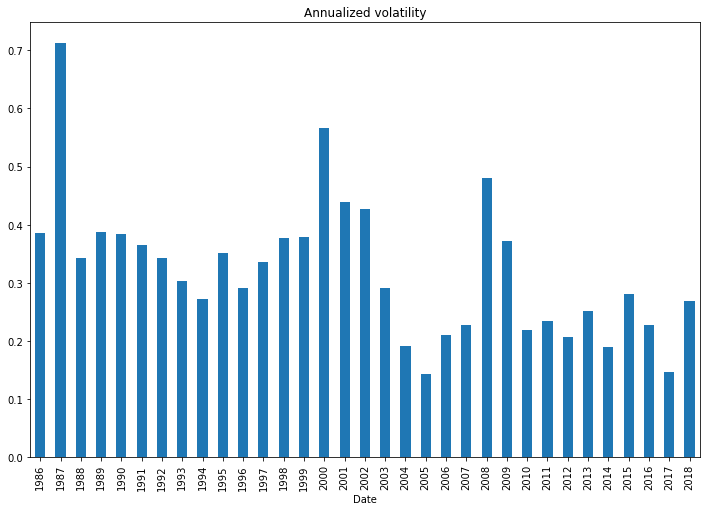

In [37]:
import volatility as v

# get daily log returns
logreturns = v.log_returns(ohlc['Close'])

# calculate volatility
vol = logreturns.groupby(logreturns.index.year).std()
vol = v.annualize_vol(vol)
vol.plot.bar(title='Annualized volatility', color='C0');

Clearly, the volatility does vary. When we calculate volatility using a whole year's worth of daily returns (as above), we can assume that differences in volatility from year to year are not simply due to noise in the data. However, we may want to calculate volatility using fewer observations in order to capture shorter-term changes. This is where an estimator such as Yang-Zhang (YZ) is useful: instead of considering only close prices, the YZ estimator uses open, high, low, and close. Because it uses multiple data points per day, the YZ estimator is able to produce a precise estimate of volatility using fewer days' worth of data.

Yang-Zhang define the *normalized* open, high low, and close price as follows, where 1 is the current period and 0 the previous, and $O$, $H$, $L$, and $C$ are the OHLC prices:

\begin{align}
o = \ln O_1 - \ln C_0 \\
u = \ln H_1 - \ln O_1 \\
d = \ln L_1 - \ln O_1 \\
c = \ln C_1 - \ln O_1 \\
\end{align}

The YZ variance estimator is defined as:

$$V = V_O + kV_C + (1 - k)V_{RS}$$

where $V_O$ and $V_C$ are the sample standard devation of $o$ and $c$, respectively.

$V_{RS}$ is the Rogers-Satchell (RS) volatility estimator, defined as:

$$V_{RS} = \frac{1}{n} \sum_{i=1}^n u_i(u_i - c_i) + d_i(d_i - c_i)$$

The YZ estimator takes opening jumps (when $O_1 \neq C_0$) into account whereas the RS estimator assumes no opening jumps.

Finally, the constant $k$ is set to:

$$k = \frac{0.34}{1.34 + \frac{n+1}{n-1}}$$

This value of $k$ is chosen so as to minimize the variance of the estimator.

We now compare the YZ estimator with the simple close-to-close volatility, focusing on the period 2000-2003 and with $n = 20$:

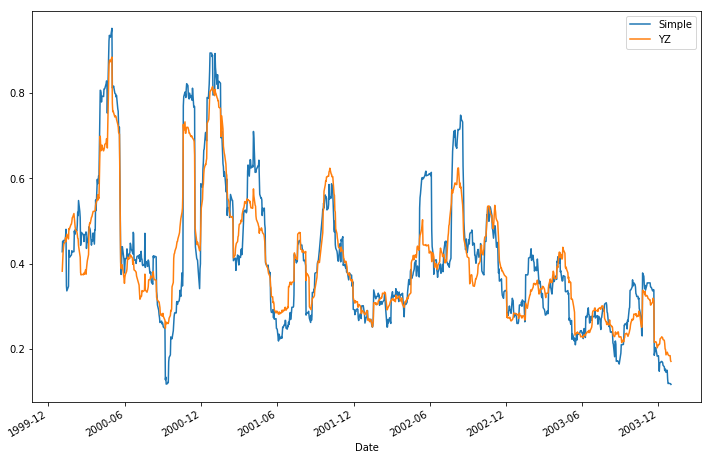

In [38]:
# calculate returns as defined in Yang-Zhang ("normalized prices")
yzr = v.yzreturns(ohlc)

vol = pd.DataFrame()
window = 20

# simple volatility
vol['Simple'] = v.simple_vol_rolling(logreturns, window)

# Yang-Zhang volatility
vol['YZ'] = v.yzvol_rolling(yzr, window)

vol.loc['2000':'2003'].plot();

One can observe that the YZ estimator has a smaller variance than the simple close-to-close estimator (visually, the YZ line is less spiky).

Note that the file `../notebooks/Volatility.ipynb` contains a widget that enables the user to change the window ($n$) and date period interactively.

## Adding volatility to our features

We now go back to our dataframe `rdf`, which contains five-day returns and 10 lagged five-day returns. Our new dataset will only contain three lagged returns.

We add the 20-day YZ volatility calculated above to the features dataframe. We lag the volatility first, so to predict returns on 1986-06-11, we would use the volatility on 1986-06-04.

Note that pandas automatically selects the correct entries from the volatility dataframe (which has daily entries) to add to the features dataframe (which has an entry every five days).

In [39]:
data = rdf.loc[:, ['Returns', 'Returns_1', 'Returns_2', 'Returns_3']]

data['Volatility'] = vol['YZ'].shift(period)  # data alignment is automatic with pandas
data.head()

,Returns,Returns_1,Returns_2,Returns_3,Volatility
Date,,,,,
1986-06-04,0.022474,0.046523,-0.023532,0.015626,0.257775
1986-06-11,-0.030080,0.022474,0.046523,-0.023532,0.250425
1986-06-18,-0.038918,-0.030080,0.022474,0.046523,0.249091
1986-06-25,-0.016002,-0.038918,-0.030080,0.022474,0.260277
1986-07-02,-0.008098,-0.016002,-0.038918,-0.030080,0.271003


In [40]:
vol['YZ'].loc['1986-06-04']

0.2504245554376233

## MACD

The Moving Average Convergence Divergence (MACD) is a "trend-following momentum indicator" (https://www.investopedia.com/terms/m/macd.asp) based on moving averages of a security's price.

The MACD is built up from the following components:

- a "fast" moving average of the price (usually a 12-day exponentially weighted moving average)
- a "slow" moving average of the price (usually a 26-day exponentially weighted moving average)

The "MACD line" is the difference between these two moving averages.

The "signal line" is a moving average (usually 9-day EWMA) of the MACD line.

When the MACD line crosses the signal line from below, this is called a "signal line crossover" and is interpreted as a signal to buy. An alternative signal is when the MACD line crosses zero (a "zero crossover").

We have implemented this indicator in a module called `technicals`.

We create a MACD object and fit it to our close prices:

In [41]:
import technicals as ti

close = raw_data['Adj Close']
macd = ti.MACD(fast=12, slow=26, signal=9)
macd.fit(close)

Now we can access the components of the MACD using the attributes of our `macd` object. We plot the price together with the fast and slow EWMAs:

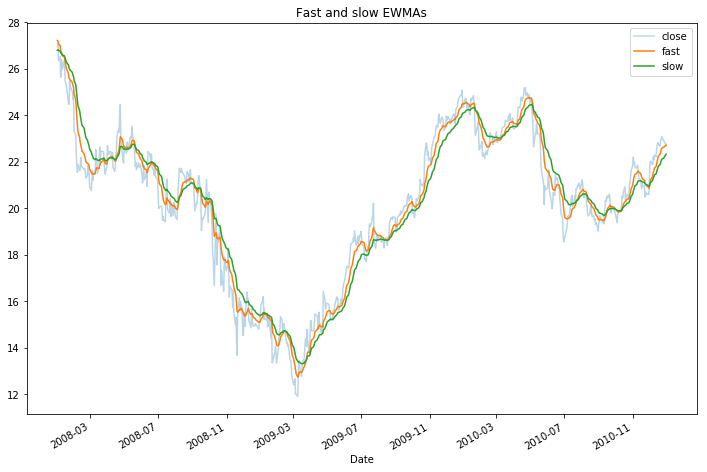

In [42]:
series_to_plot = dict(close=close, 
                      fast=macd.fast_ewma,
                      slow=macd.slow_ewma,
                      macd=macd.macd_line,
                      signal=macd.signal_line,
                      divergence=macd.divergence                         
                     )
df = pd.DataFrame(series_to_plot)

start = '2008'
end = '2010'
df = df.loc[start:end]

df.close.plot(alpha=0.3, title="Fast and slow EWMAs")  # make the close price line slightly transparent
df.fast.plot()
df.slow.plot()
plt.legend();

Next, we plot the MACD and signal lines.

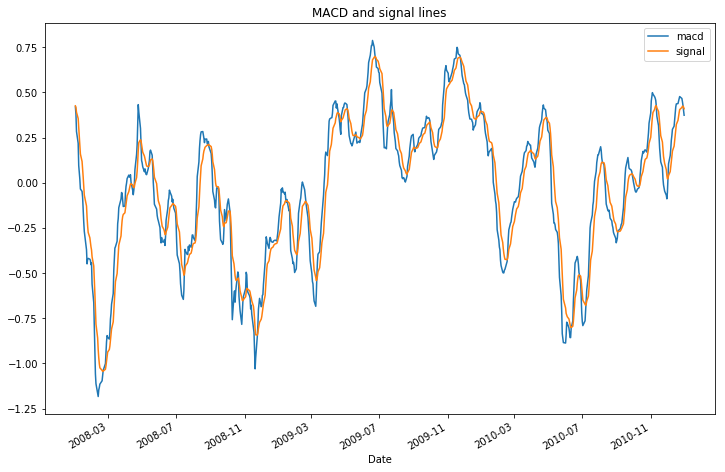

In [43]:
df[['macd', 'signal']].plot(title="MACD and signal lines");

Finally, we plot the divergence line:

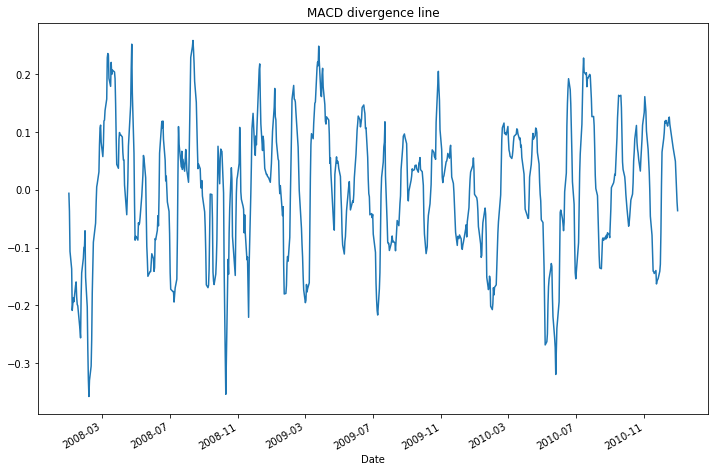

In [44]:
df.divergence.plot(title="MACD divergence line");

Now we add the signal and zero crossovers to our feature set. As we did for the volatility feature, we lag these features because they will be used to predict the current return.

In [45]:
data['MACD_signal_xover'] = macd.signal_xover.shift(period)
data['MACD_zero_xover'] = macd.zero_xover.shift(period)
data.dropna(inplace=True)
data.head()

,Returns,Returns_1,Returns_2,Returns_3,Volatility,MACD_signal_xover,MACD_zero_xover
Date,,,,,,,
1986-06-04,0.022474,0.046523,-0.023532,0.015626,0.257775,0.0,1.0
1986-06-11,-0.030080,0.022474,0.046523,-0.023532,0.250425,1.0,1.0
1986-06-18,-0.038918,-0.030080,0.022474,0.046523,0.249091,0.0,1.0
1986-06-25,-0.016002,-0.038918,-0.030080,0.022474,0.260277,0.0,0.0
1986-07-02,-0.008098,-0.016002,-0.038918,-0.030080,0.271003,0.0,0.0


Finally, we perform the train-test-split again:

In [46]:
train_proportion = 0.8
n = len(data)
t = round(n*train_proportion)

target = (data['Returns'] > 0).astype(int)
features = data.drop(columns='Returns')

train_target = target.iloc[:t]
train_features = features.iloc[:t]

test_target = target.iloc[t:]
test_features = features.iloc[t:]

## Logistic regression

We now try logistic regression with our new, augmented data set. We get similar results to earlier:

In [62]:
slg.penalty = 'l2'
slg.fit(train_features, train_target)
slg.score(test_features, test_target)

0.5762195121951219

In [48]:
test_predictions = slg.predict(test_features)
confusion_df(test_target, test_predictions)

prediction,down,up
target,,
down,10,128
up,11,179


Interestingly, although L1 regularization does not lead to a greatly improved score, the coefficient vector reveals that our new features are the only ones to be selected: all three lagged returns have a zero coefficient.

In [61]:
slg.penalty = 'l1'
slg.fit(train_features, train_target)
slg.score(test_features, test_target)

0.5792682926829268

In [50]:
slg.coef_

array([[ 0.        ,  0.        ,  0.        , -0.12564415, -0.16341957,
         0.00401881]])

## Support vector machine

We now train a SVM classifier on our new data. The score is not improved.

In [60]:
clf = LinearSVC()
clf.fit(train_features, train_target)
clf.score(test_features, test_target)

0.5609756097560976

## Decision tree

The decision tree does worse than before!

In [59]:
clf = DecisionTreeClassifier(max_depth=3, random_state=0)  # set the random state to make results reproducible
clf.fit(train_features, train_target)
clf.score(test_features, test_target)

0.5091463414634146

We visualize the tree below. Note that it is making use of the volatility and two of the lagged returns, but neither MACD indicator.

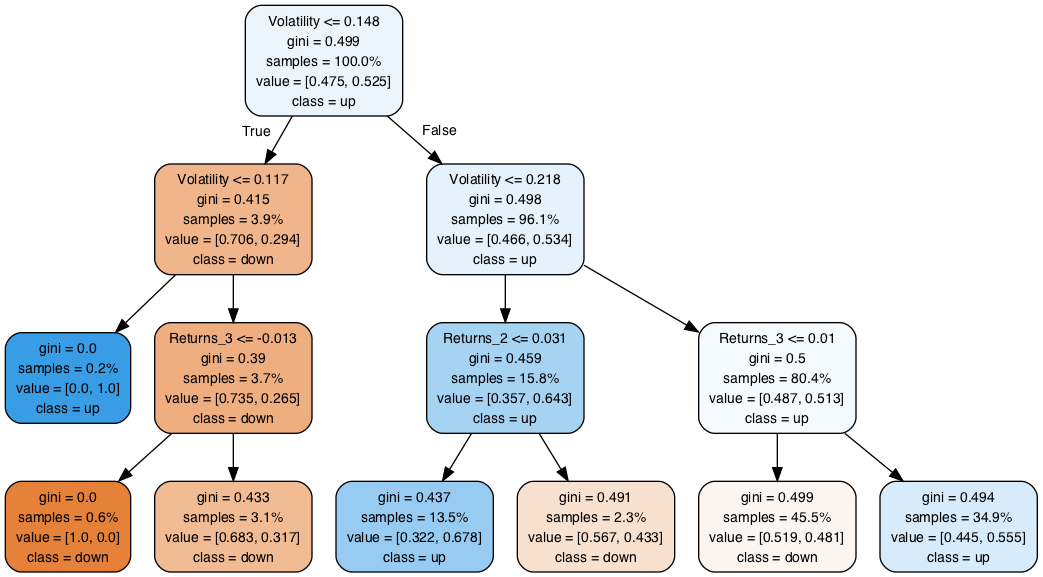

In [53]:
dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=train_features.columns, 
                           class_names=['down', 'up'],
                           filled=True,
                           rounded=True,
                           proportion=True
                          )
graph = graphviz.Source(dot_data, filename='../notebooks/tree2', format='png')
graph.render()
Image('../notebooks/tree2.png')

For the first time, the predictions are not "up" all the time! This is more clearly seen with the confusion matrix:

In [54]:
test_predictions = clf.predict(test_features)
confusion_df(test_target, test_predictions)

prediction,down,up
target,,
down,54,84
up,77,113


We remove the lagged returns and generate a new tree using only the volatility and MACD features.

In [64]:
train_features_reduced = train_features.iloc[:, 3:]
test_features_reduced = test_features.iloc[:, 3:]

clf = DecisionTreeClassifier(max_depth=3, random_state=0)  # set the random state to make results reproducible
clf.fit(train_features_reduced, train_target)
clf.score(test_features_reduced, test_target)

0.5182926829268293

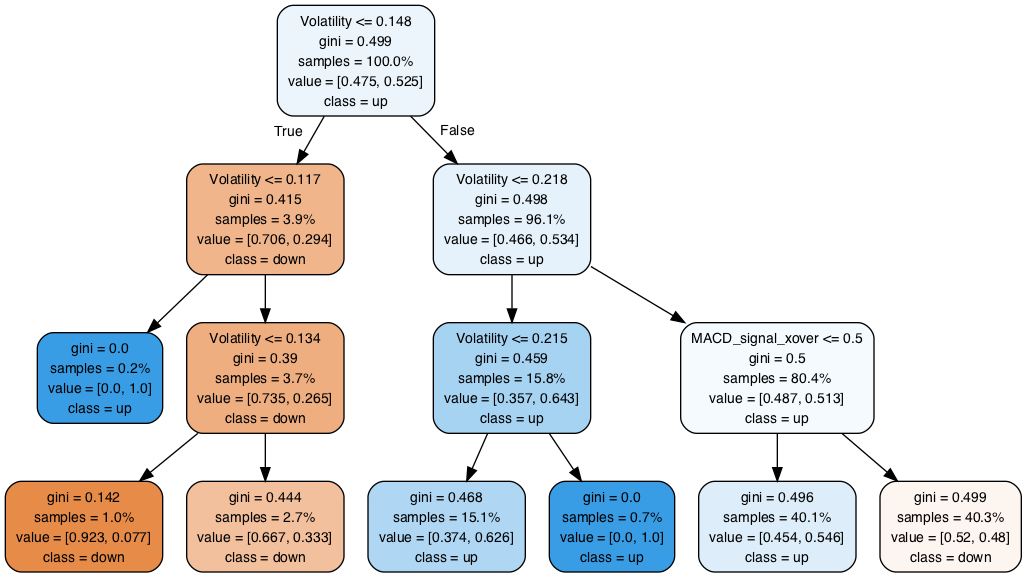

In [66]:
dot_data = export_graphviz(clf, out_file=None, 
                           feature_names=train_features_reduced.columns, 
                           class_names=['down', 'up'],
                           filled=True,
                           rounded=True,
                           proportion=True
                          )
graph = graphviz.Source(dot_data, filename='../notebooks/tree3', format='png')
graph.render()
Image('../notebooks/tree3.png')

The score is slightly better, but we now see the MACD signal crossover being used. In fact, the tree could be summarized as follows, denoting volatility as $V$:

- if $V \leq 11.7\%$ (true for 0.2% of the training set) predict up
- if $11.7\% \lt V \leq 14.8\%$, (true for 3.7% of the training set) predict down
- if $14.8\% \lt V \leq 21.8\%$, (true for 15.8% of the training set), predict up
- if $V \gt 21.8\%$ (true for 80.4% of the training set), use the MACD signal crossover: if 0 predict up (40.1% of cases), else predict down (40.3% of cases).

In 80.4% of cases, the prediction is determined by the MACD signal crossover. However, the prediction is counterintuitive: a negative crossover results (usually interpreted as a sell signal) results in a positive return prediction!

# Conclusion

We applied three machine learning techniques to the task of predicting stock return direction: logistic regression, support vector machines, and decision trees. Before attempting to predict returns, we demonstrated that our implentation of logistic regression produced the same coefficients as the scikit-learn implementation.

Initially, our features consisted solely of previous returns. All three techniques predicted positive returns close to 100% of the time, reflecting the fact that the training data contained more positive than negative returns. The lagged returns did not appear to have much predictive power. This was highlighted by feature selection using L1 regularization: all but two of the lagged returns received a zero coefficient.

In order to improve our predictions, we generated three additional features. The first of these was the volatility, calculated using the Yang-Zhang estimator. The other two additional features come from the MACD technical indicator: the signal line crossover and zero line crossover. The logistic regression and support vector machine produced similar results as in the case with only lagged returns. However, the decision tree predicted up 58% of the time instead of 95%. The MACD signals were not used by this tree, but when the lagged returns were removed from the features (leaving only volatility and MACD features), the resulting decision tree used the signal crossover indicator to determine the prediction for 80% of the samples.

We were unable to find a combination of machine learning technique and features that produced a reliable prediction of the return. Techniques such as deep neural networks and ensemble learning (which we were unable to test, due to time constraints) may produce better results. However, we are likely to need better features too: in particular, features derived from fundamental analysis of the stock in question may have more predictive power. Finally, one should not forget that predicting stock returns is a famously difficult task - indeed, some might argue that it is impossible.

## References

- Yang, D. and Zhang, Q. (2000). Drift Independent Volatility Estimation Based on High, Low, Open, and Close Prices. The Journal of Business, [online] 73(3), pp.477-492. Available at: https://www.jstor.org/stable/10.1086/209650.

- Geron, A. (2017). *Hands-On Machine Learning with Scikit-Learn and TensorFlow*, 1st ed. O'Reilly Media. Ch.4